<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 4.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*

---

# Análise dos Dados do Airbnb - *Oslo*

O [Airbnb](https://www.airbnb.com.br/) já é considerado como sendo a **maior empresa hoteleira da atualidade**. Ah, o detalhe é que ele **não possui nenhum hotel**!

Conectando pessoas que querem viajar (e se hospedar) com anfitriões que querem alugar seus imóveis de maneira prática, o Airbnb fornece uma plataforma inovadora para tornar essa hospedagem alternativa.

No final de 2018, a Startup fundada 10 anos atrás, já havia **hospedado mais de 300 milhões** de pessoas ao redor de todo o mundo, desafiando as redes hoteleiras tradicionais.

Uma das iniciativas do Airbnb é disponibilizar dados do site, para algumas das principais cidades do mundo. Por meio do portal [Inside Airbnb](http://insideairbnb.com/get-the-data.html), é possível baixar uma grande quantidade de dados para desenvolver projetos e soluções de *Data Science*.

<center><img alt="Analisando Airbnb" width="10%" src="https://www.area360.com.au/wp-content/uploads/2017/09/airbnb-logo.jpg"></center>

**Neste *notebook*, iremos analisar os dados referentes à cidade Oslo, e ver quais insights podem ser extraídos a partir de dados brutos.**

## Obtenção dos Dados

Todos os dados usados aqui foram obtidos a partir do site [Inside Airbnb](http://insideairbnb.com/get-the-data.html).

Para esta análise exploratória inicial, será baixado apenas o seguinte arquivo:

* `listings.csv` - *Summary information and metrics for listings in Rio de Janeiro (good for visualisations).*

Importante: O portal está em constante evolução, e em determinado momento, pode ser que o [conjunto de dados](https://data.insideairbnb.com/norway/oslo/oslo/2025-09-29/visualisations/listings.csv) exato utilizado nesse notebook não esteja mais disponível, o que quebraria nosso código.


Com isso em mente, vamos ao projeto.

**Dicionário das variáveis**

* `id` - número de id gerado para identificar o imóvel
* `name` - nome da propriedade anunciada
* `host_id` - número de id do proprietário (anfitrião) da propriedade
* `host_name` - Nome do anfitrião
* `neighbourhood_group` - esta coluna não contém nenhum valor válido
* `neighbourhood` - nome do bairro
* `latitude` - coordenada da latitude da propriedade
* `longitude` - coordenada da longitude da propriedade
* `room_type` - informa o tipo de quarto que é oferecido
* `price` - preço para alugar o imóvel
* `minimum_nights` - quantidade mínima de noites para reservar
* `number_of_reviews` - número de reviews que a propriedade possui
* `last_review` - data do último review
* `reviews_per_month` - quantidade de reviews por mês
* `calculated_host_listings_count` - quantidade de imóveis do mesmo anfitrião
* `availability_365` - número de dias de disponibilidade dentro de 365 dias

Antes de iniciar qualquer análise, vamos verificar a cara do nosso *dataset*, analisando as 5 primeiras entradas.

In [ ]:
# importar os pacotes necessarios

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


In [2]:
# importar o arquivo listings.csv para um DataFrame
# mostrar as 5 primeiras entradas

df = pd.read_csv(r"https://data.insideairbnb.com/norway/oslo/oslo/2025-09-29/visualisations/listings.csv")
df.head() # por default são as 5 primeiras 

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,42932,"Charming apartment, Oslo Center, Ro",187463,Cecilie,NaN,Frogner,59.91201,10.72455,Entire home/apt,2166.0,4,55,2025-08-12,0.37,2,2,1,NaN
1,71725,Central big room - ap with balcony,368229,Reidun,NaN,Gamle Oslo,59.90795,10.77987,Private room,467.0,14,59,2025-09-01,0.33,1,257,3,NaN
2,85902,"Eclectic design home, super central",250159,Melissa,NaN,Gamle Oslo,59.91074,10.77232,Entire home/apt,1800.0,2,82,2025-05-21,0.47,1,28,1,NaN
3,149776,Bird's nest in the heart of Oslo,714768,Henrik,NaN,St. Hanshaugen,59.92398,10.74787,Private room,946.0,4,46,2025-08-29,0.27,2,365,2,NaN
4,165218,"Bedroom, nice riverview, in Oslo",787976,Jon,NaN,Sagene,59.93750,10.76554,Private room,NaN,2,32,2025-09-14,0.19,1,0,8,NaN


#### Limpando o dataset

In [32]:
def iqr(df,col):
    q1_price = df[col].quantile(.25)
    q3_price = df[col].quantile(.75)
    IQR_price = q3_price - q1_price
    sup = q3_price + 1.5 * IQR_price
    inf = q1_price - 1.5 * IQR_price
    print(f'IQR da variável {col}: {IQR_price}, Limite inferior: {inf} e Limite superior: {sup}')

In [40]:
def box(df, col):
    q1_price = df[col].quantile(.25)
    q3_price = df[col].quantile(.75)
    IQR_price = q3_price - q1_price
    sup = q3_price + 1.5 * IQR_price
    #inf = q1_price - 1.5 * IQR_price
    fig, ax = plt.subplots(figsize=(15,3))
    df[col].plot(kind='box', vert=False)
    ax.set_title(f'Dataset Original - {col}')
    plt.show()
    print("O dataset possui {} colunas".format(df.shape[0]))
    print("{} Entradas acima de {}".format(len(df[df[col] > sup]), sup))
    print("Representam {:.2f}% do dataset".format((len(df[df[col] > sup]) / df.shape[0])*100))

In [33]:
cols = ['minimum_nights','price','number_of_reviews','calculated_host_listings_count','availability_365']

for i in cols:
    iqr(df,i)

IQR da variável minimum_nights: 2.0, Limite inferior: -1.0 e Limite superior: 7.0
IQR da variável price: 882.0, Limite inferior: -406.0 e Limite superior: 3122.0
IQR da variável number_of_reviews: 16.0, Limite inferior: -22.0 e Limite superior: 42.0
IQR da variável calculated_host_listings_count: 0.0, Limite inferior: 1.0 e Limite superior: 1.0
IQR da variável availability_365: 269.0, Limite inferior: -403.5 e Limite superior: 672.5


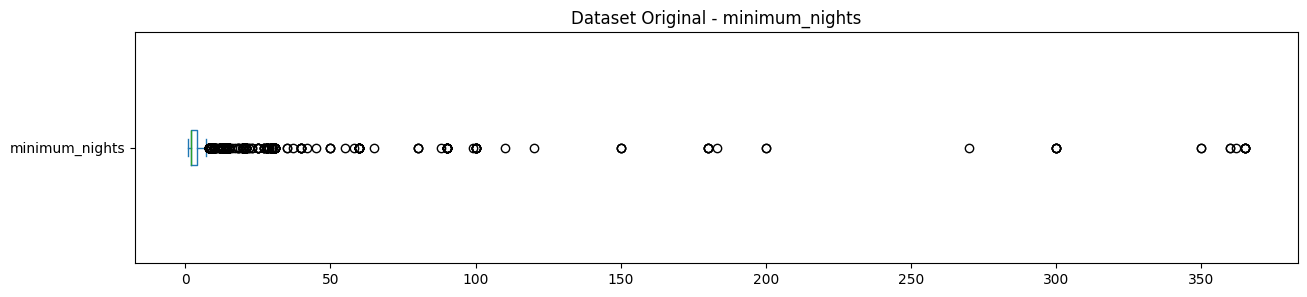

O dataset possui 12160 colunas
634 Entradas acima de 7.0
Representam 5.21% do dataset


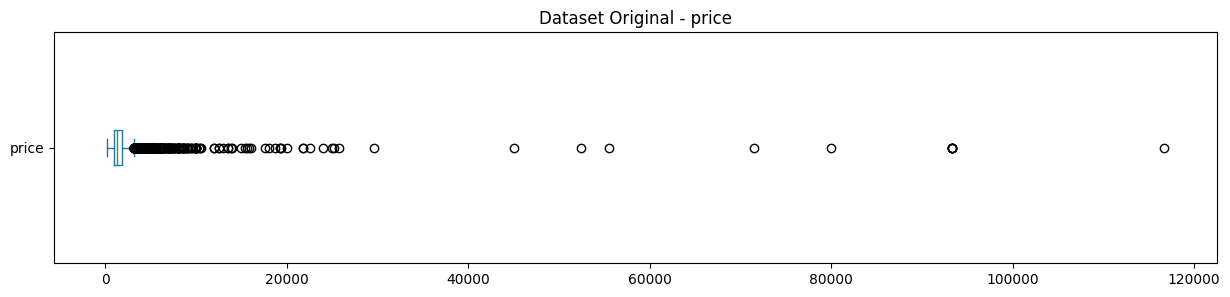

O dataset possui 12160 colunas
546 Entradas acima de 3122.0
Representam 4.49% do dataset


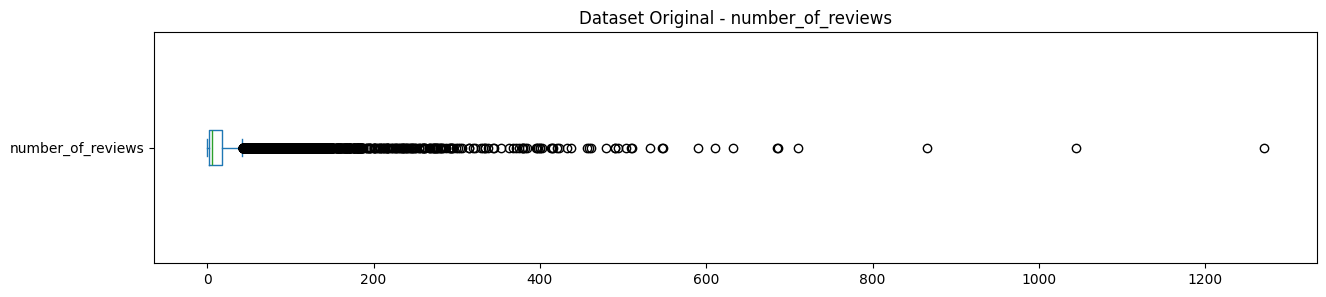

O dataset possui 12160 colunas
1357 Entradas acima de 42.0
Representam 11.16% do dataset


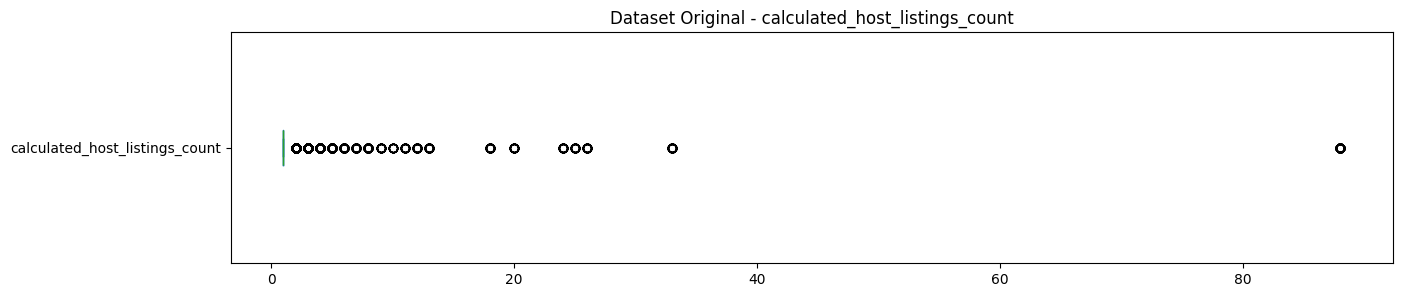

O dataset possui 12160 colunas
2195 Entradas acima de 1.0
Representam 18.05% do dataset


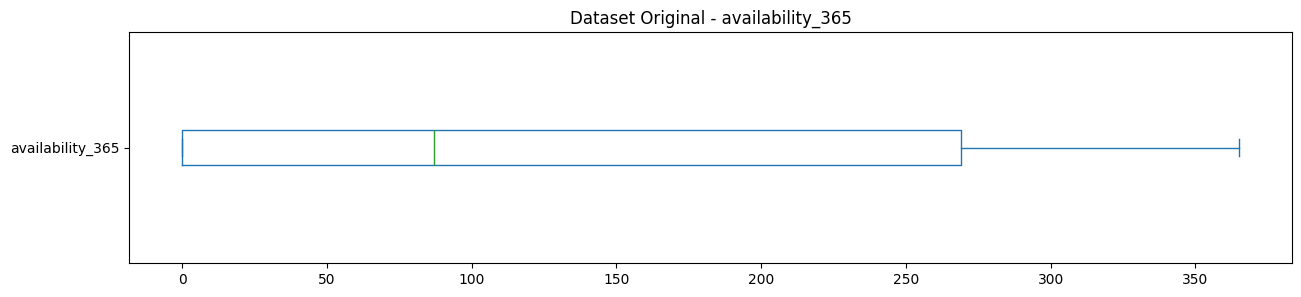

O dataset possui 12160 colunas
0 Entradas acima de 672.5
Representam 0.00% do dataset


In [41]:
cols = ['minimum_nights','price','number_of_reviews','calculated_host_listings_count','availability_365']

for i in cols:
    box(df, i)

In [ ]:
cols = ['minimum_nights','price','number_of_reviews','calculated_host_listings_count','availability_365']

for i in cols:
    iqr(df,i)

In [42]:
# limpando o dataset
df_clean = df.copy()

df_clean.drop(df_clean[df_clean.minimum_nights > 7].index, axis=0, inplace=True)
df_clean.drop(df_clean[df_clean.price > 3122].index, axis=0, inplace=True)
df_clean.drop(df_clean[df_clean.price == 0.0].index, axis=0, inplace=True)



print('Shape antes da limpeza: ', df.shape)
print('Shape após a limpeza: ',df_clean.shape)

Shape antes da limpeza:  (12160, 18)
Shape após a limpeza:  (11008, 18)


In [47]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11008 entries, 0 to 12159
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              11008 non-null  int64  
 1   name                            11008 non-null  object 
 2   host_id                         11008 non-null  int64  
 3   host_name                       11005 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   11008 non-null  object 
 6   latitude                        11008 non-null  float64
 7   longitude                       11008 non-null  float64
 8   room_type                       11008 non-null  object 
 9   price                           7749 non-null   float64
 10  minimum_nights                  11008 non-null  int64  
 11  number_of_reviews               11008 non-null  int64  
 12  last_review                     9363 

In [48]:
df_clean.price.fillna(df_clean.price.median(), inplace=True)

C:\Users\Bruno Melo\AppData\Local\Temp\ipykernel_6540\2786922490.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean.price.fillna(df_clean.price.median(), inplace=True)


In [49]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11008 entries, 0 to 12159
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              11008 non-null  int64  
 1   name                            11008 non-null  object 
 2   host_id                         11008 non-null  int64  
 3   host_name                       11005 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   11008 non-null  object 
 6   latitude                        11008 non-null  float64
 7   longitude                       11008 non-null  float64
 8   room_type                       11008 non-null  object 
 9   price                           11008 non-null  float64
 10  minimum_nights                  11008 non-null  int64  
 11  number_of_reviews               11008 non-null  int64  
 12  last_review                     9363 

In [50]:
df_clean.drop(columns=['license','neighbourhood_group'], inplace=True)

In [51]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11008 entries, 0 to 12159
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              11008 non-null  int64  
 1   name                            11008 non-null  object 
 2   host_id                         11008 non-null  int64  
 3   host_name                       11005 non-null  object 
 4   neighbourhood                   11008 non-null  object 
 5   latitude                        11008 non-null  float64
 6   longitude                       11008 non-null  float64
 7   room_type                       11008 non-null  object 
 8   price                           11008 non-null  float64
 9   minimum_nights                  11008 non-null  int64  
 10  number_of_reviews               11008 non-null  int64  
 11  last_review                     9363 non-null   object 
 12  reviews_per_month               9363 

### **Q1. Quantos atributos (variáveis) e quantas entradas o nosso conjunto de dados possui? Quais os tipos das variáveis?**

In [52]:
print(f'Nº de observações {df_clean.shape[0]:,}')
print(f'Nº de covariáveis  {df_clean.shape[1]}')
df_clean.info()

Nº de observações 11,008
Nº de covariáveis  16
<class 'pandas.core.frame.DataFrame'>
Index: 11008 entries, 0 to 12159
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              11008 non-null  int64  
 1   name                            11008 non-null  object 
 2   host_id                         11008 non-null  int64  
 3   host_name                       11005 non-null  object 
 4   neighbourhood                   11008 non-null  object 
 5   latitude                        11008 non-null  float64
 6   longitude                       11008 non-null  float64
 7   room_type                       11008 non-null  object 
 8   price                           11008 non-null  float64
 9   minimum_nights                  11008 non-null  int64  
 10  number_of_reviews               11008 non-null  int64  
 11  last_review                     9363 non-null   obj

### **Q2. Qual a porcentagem de valores ausentes no *dataset*?**

In [54]:
percent = (df.isna().sum() / df.shape[0]) * 100
percent.round(2).sort_values(ascending=False)

license                           100.00
neighbourhood_group               100.00
reviews_per_month                  16.87
last_review                        16.87
host_name                           0.03
id                                  0.00
name                                0.00
latitude                            0.00
host_id                             0.00
neighbourhood                       0.00
price                               0.00
room_type                           0.00
longitude                           0.00
number_of_reviews                   0.00
minimum_nights                      0.00
calculated_host_listings_count      0.00
availability_365                    0.00
number_of_reviews_ltm               0.00
dtype: float64

In [55]:
percent = (df_clean.isna().sum() / df_clean.shape[0]) * 100
percent.round(2).sort_values(ascending=False)

reviews_per_month                 14.94
last_review                       14.94
host_name                          0.03
id                                 0.00
neighbourhood                      0.00
latitude                           0.00
name                               0.00
host_id                            0.00
room_type                          0.00
longitude                          0.00
minimum_nights                     0.00
price                              0.00
number_of_reviews                  0.00
calculated_host_listings_count     0.00
availability_365                   0.00
number_of_reviews_ltm              0.00
dtype: float64

### **Q3. Qual o tipo de distribuição das variáveis?**

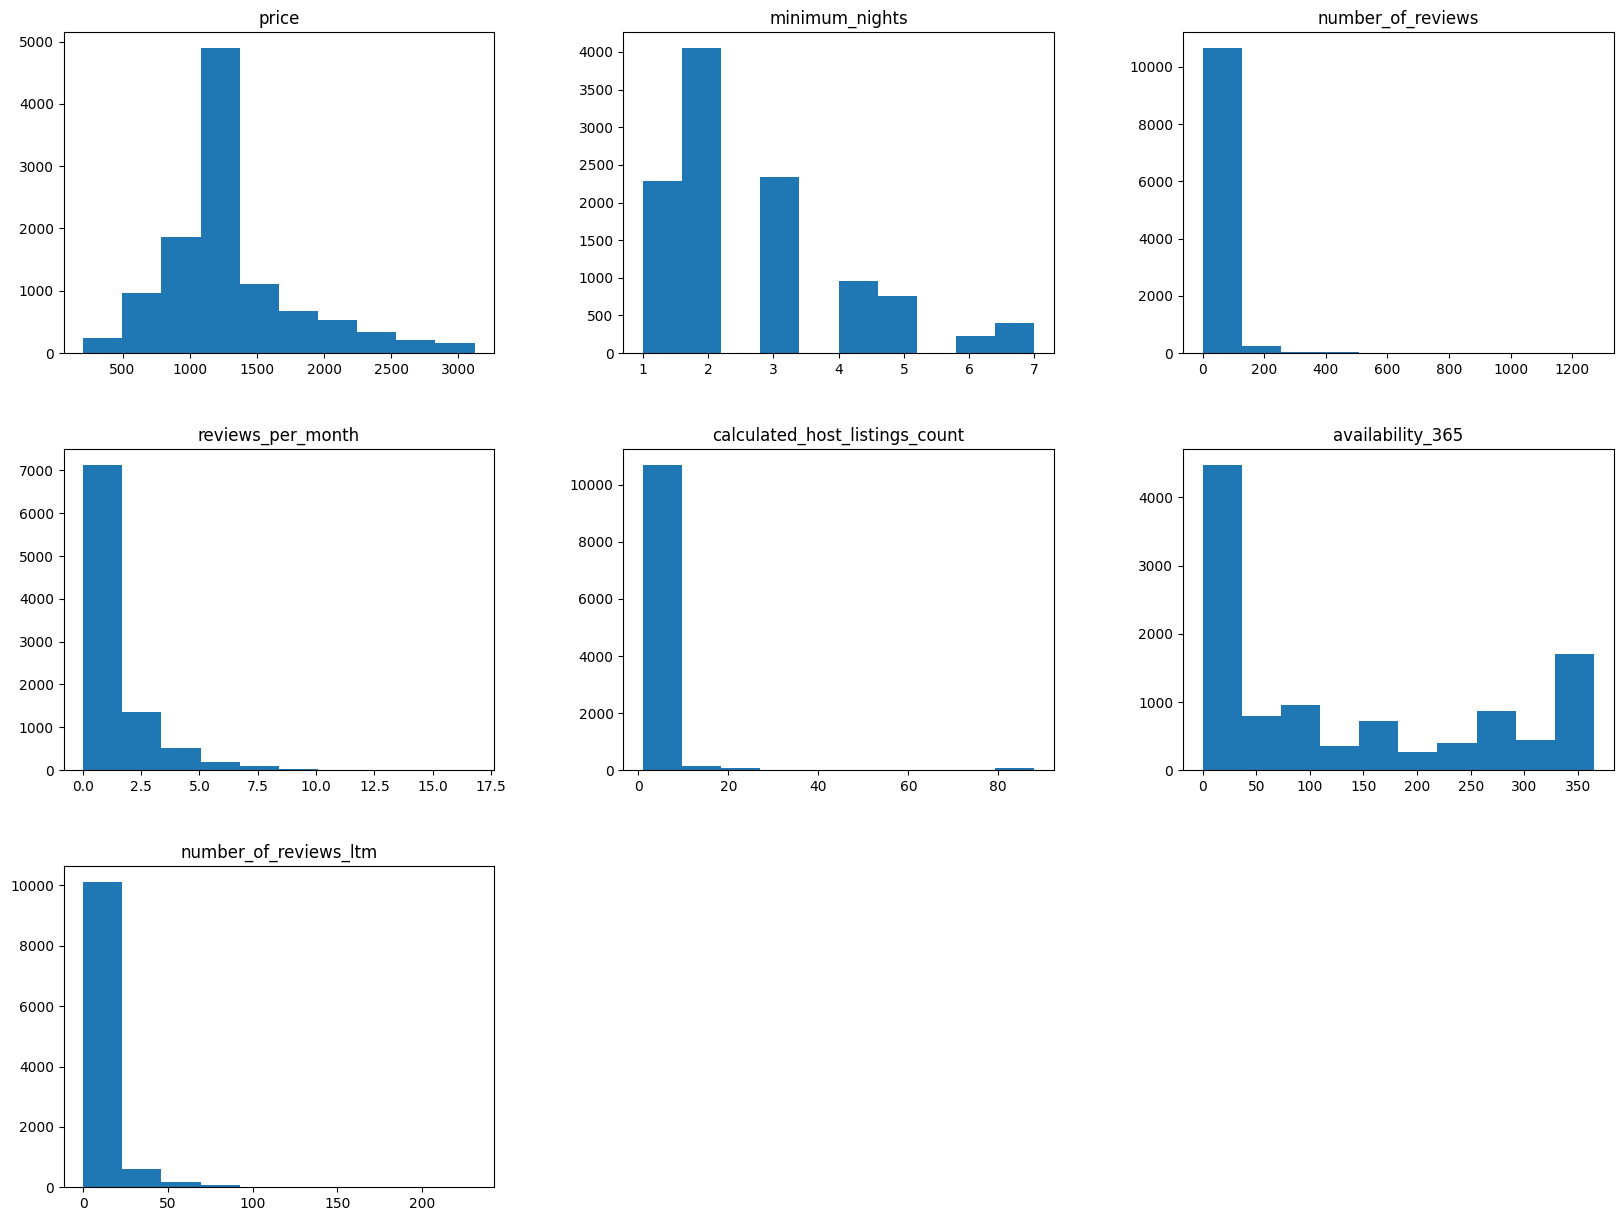

In [56]:
df_clean[['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','number_of_reviews_ltm']].hist(figsize=[20,15], grid=False);

### **Q4. Qual a média dos preços de aluguel?**

In [57]:
print(df.price.mean())
print(df_clean.price.mean())

1554.2763157894738
1298.387082122093


### **Q4. Qual a correlação existente entre as variáveis**

In [58]:
df_corr = df_clean[['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','number_of_reviews_ltm']].copy()
df_corr.select_dtypes(include='number').corr().round(2)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
price,1.00,0.10,-0.10,-0.14,-0.06,0.15,-0.11
minimum_nights,0.10,1.00,-0.12,-0.29,-0.02,-0.10,-0.20
number_of_reviews,-0.10,-0.12,1.00,0.44,0.16,0.06,0.65
reviews_per_month,-0.14,-0.29,0.44,1.00,0.09,0.14,0.75
calculated_host_listings_count,-0.06,-0.02,0.16,0.09,1.00,0.14,0.15
availability_365,0.15,-0.10,0.06,0.14,0.14,1.00,0.11
number_of_reviews_ltm,-0.11,-0.20,0.65,0.75,0.15,0.11,1.00


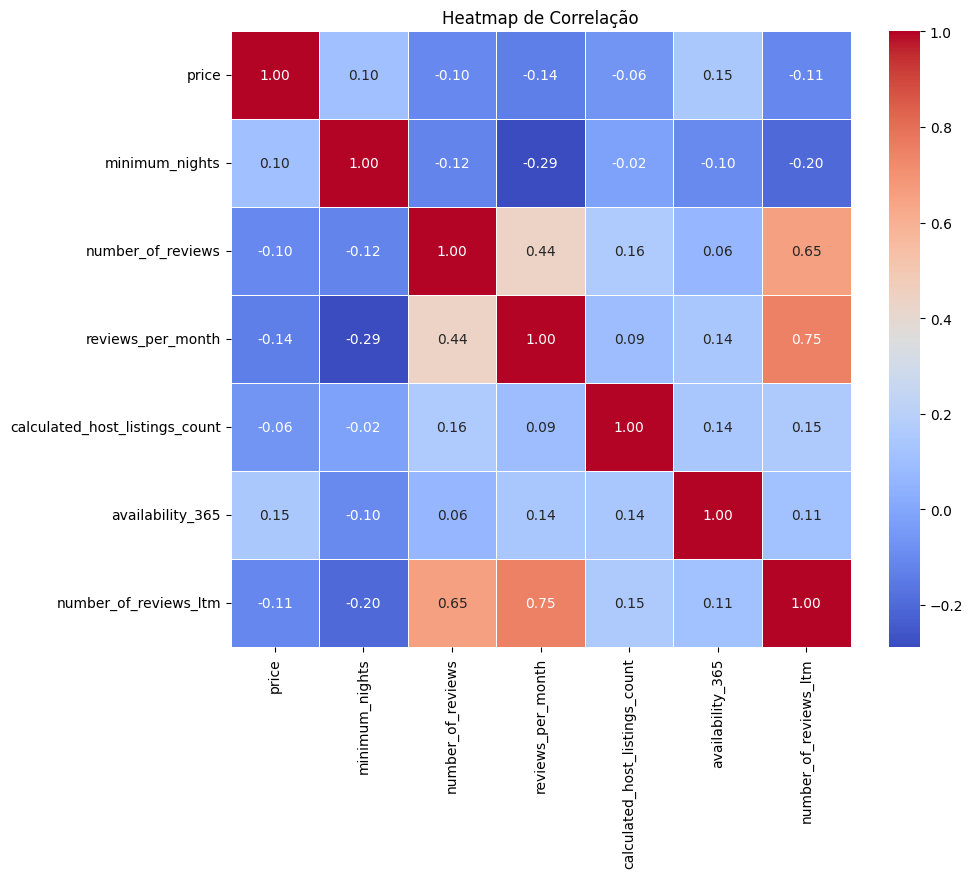

In [59]:
corr = (
    df_corr
    .select_dtypes(include='number')
    .corr()
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Heatmap de Correlação")
plt.show()


### **Q5. Qual o tipo de imóvel mais alugado no Airbnb?**

In [60]:
df_clean.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')

In [16]:
df.room_type.value_counts()

room_type
Entire home/apt    10755
Private room        1363
Shared room           42
Name: count, dtype: int64

In [61]:
df_clean.room_type.value_counts()

room_type
Entire home/apt    9709
Private room       1262
Shared room          37
Name: count, dtype: int64

In [17]:
percent = (df.room_type.value_counts() / df.shape[0]) * 100
percent.round(2).sort_values(ascending=False)

room_type
Entire home/apt    88.45
Private room       11.21
Shared room         0.35
Name: count, dtype: float64

In [62]:
percent = (df_clean.room_type.value_counts() / df_clean.shape[0]) * 100
percent.round(2).sort_values(ascending=False)

room_type
Entire home/apt    88.20
Private room       11.46
Shared room         0.34
Name: count, dtype: float64

### **Q6. Qual a localidade mais cara do dataset?**

In [19]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

In [20]:
df.neighbourhood.unique()

array(['Frogner', 'Gamle Oslo', 'St. Hanshaugen', 'Sagene', 'Nordstrand',
       'Grünerløkka', 'Nordre Aker', 'Sentrum', 'Bjerke', 'Vestre Aker',
       'Ullern', 'Søndre Nordstrand', 'Østensjø', 'Alna', 'Grorud',
       'Stovner', 'Marka'], dtype=object)

In [64]:
df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

neighbourhood
Frogner              2024.663524
Nordstrand           1945.848771
Vestre Aker          1831.759563
Sentrum              1702.808290
Grorud               1645.031915
Bjerke               1625.517572
Ullern               1531.609971
Gamle Oslo           1520.933892
St. Hanshaugen       1514.844316
Marka                1498.706897
Østensjø             1458.370492
Nordre Aker          1440.587583
Grünerløkka          1380.726846
Søndre Nordstrand    1312.758621
Sagene               1288.426579
Stovner              1114.654545
Alna                 1101.003876
Name: price, dtype: float64

In [63]:
df_clean.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

neighbourhood
Sentrum              1455.888889
Vestre Aker          1432.242718
Frogner              1418.437118
Nordstrand           1406.595349
Nordre Aker          1326.696296
St. Hanshaugen       1317.642914
Ullern               1317.076412
Gamle Oslo           1301.394522
Grünerløkka          1284.968276
Marka                1281.787234
Sagene               1209.747026
Østensjø             1201.524648
Bjerke               1165.110000
Søndre Nordstrand    1101.900763
Grorud               1081.247191
Stovner              1024.860000
Alna                 1003.448980
Name: price, dtype: float64

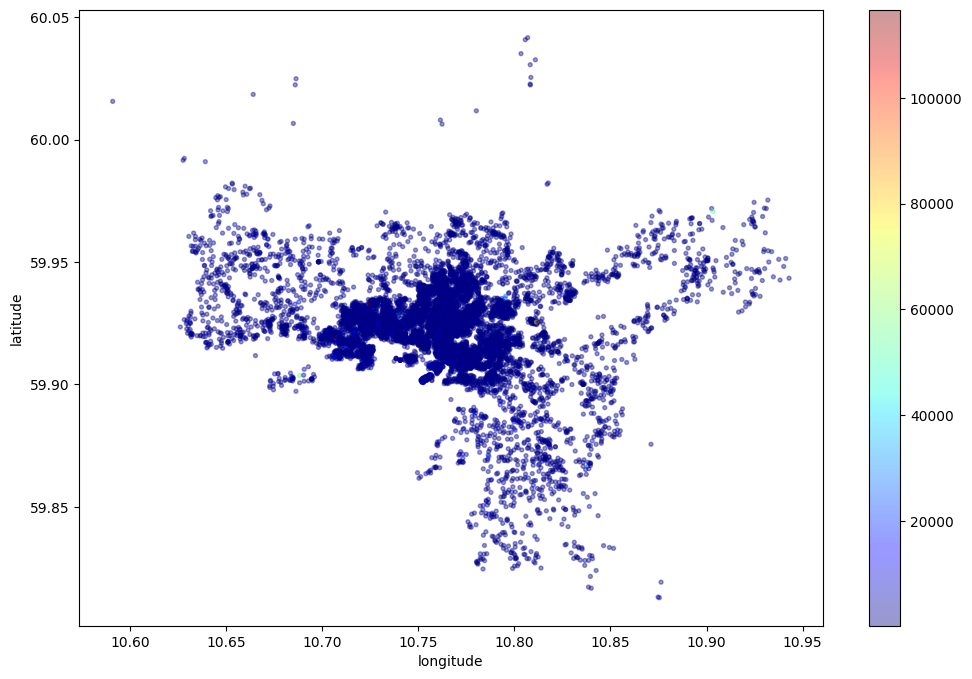

In [65]:
# plotar os imóveis pela latitude-longitude

df.plot(kind="scatter", x='longitude', y='latitude', alpha=0.4, c=df['price'], s=8,
              cmap=plt.get_cmap('jet'), figsize=(12,8));

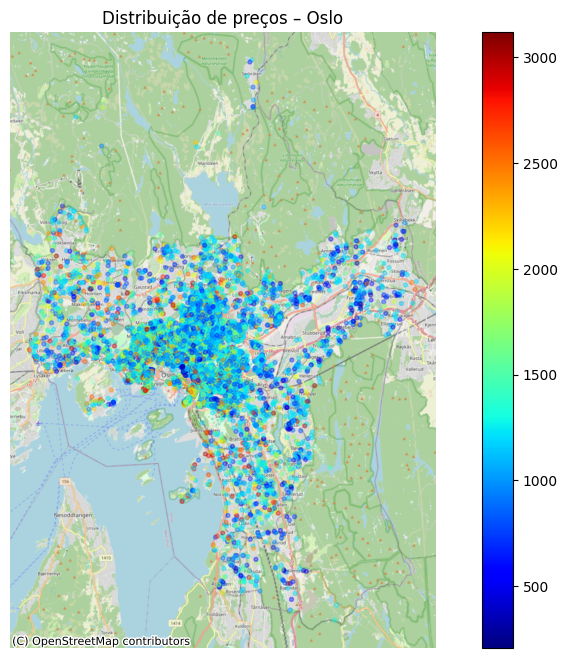

In [66]:
# transformar o df em GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean.longitude, df_clean.latitude),
    crs="EPSG:4326"  # lat/long
)

# projetar para Web Mercator (necessário para mapas)
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 8))

gdf.plot(
    ax=ax,
    column='price',
    cmap='jet',
    markersize=8,
    alpha=0.4,
    legend=True
)

# adicionar mapa de fundo (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Distribuição de preços – Oslo")
ax.set_axis_off()

plt.show()


### **Q7. Qual é a média do mínimo de noites para aluguel (minimum_nights)?**

In [26]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

In [67]:
print(df.minimum_nights.mean())
print(df_clean.minimum_nights.mean())

4.304440789473684
2.645984738372093
